# Titanic Survival — From Passenger Stories to Defensible Predictions

Behind every survivor is a pattern—of **class**, **gender**, **age**, **cabin deck**, and **whether they traveled alone**.  
In this notebook, we turn those patterns into a testable model of survival and defend each step with evidence.

---

## Introduction

- **Question:** Who was more likely to survive—and why?  
- **Goal:** Build a predictive model for `Survived` and explain the drivers clearly.  
- **Approach:** Focused EDA → human-readable feature engineering → Logistic baseline + RandomForest → **F1-tuned threshold** → `submission.csv`.

---

# Imports Libraries 

In [376]:
import re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve, validation_curve
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, precision_recall_curve
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)

RNG = 42
FAST_MODE = True
np.random.seed(RNG)

# Load Data 

In [377]:
from pathlib import Path

def _resolve_data_paths():
    # Local (recommended)
    local_train = Path("data/raw/train.csv")
    local_test  = Path("data/raw/test.csv")
    if local_train.exists() and local_test.exists():
        return local_train, local_test

    # Kaggle default
    kaggle_train = Path("/kaggle/input/titanic/train.csv")
    kaggle_test  = Path("/kaggle/input/titanic/test.csv")
    if kaggle_train.exists() and kaggle_test.exists():
        return kaggle_train, kaggle_test

    raise FileNotFoundError(
        "Could not find train/test CSV files.\n"
        "Place them under: data/raw/train.csv and data/raw/test.csv"
    )

train_path, test_path = _resolve_data_paths()
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
passenger_ids = test_df["PassengerId"].copy()

print(f"Loaded train: {train_path} -> {train_df.shape}")
print(f"Loaded test : {test_path} -> {test_df.shape}")


# Quick EDA


In [378]:
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [379]:
print(test_df.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [380]:
print(train_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [381]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None


In [382]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## Data Cleaning

Like any good refit, we fix what’s broken before sailing out:

- **Missing values**
  - `Embarked`: fill with the most frequent category.
  - `Fare`: fill by **median within `Pclass`** (fairer across fare bands).
  - `Age`: imputations via **median of `(Title, Sex, Pclass)`** with a global fallback.
- **Duplicates/outliers:** checked visually and via simple rules of thumb.

> These choices keep leakage low and reflect plausible shipboard realities.

In [383]:
missing_values = {"train": train_df.isnull().sum(), "test": test_df.isnull().sum()}
print(missing_values)

{'train': PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64, 'test': PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64}


## Exploratory Data Analysis (EDA)

Numbers whisper; plots speak up:

- **Survival by Sex:** clear differences in rates.  
- **Survival by Pclass:** first class had higher survival.  
- **Age Distributions:** children show distinct behavior.  
- **Embarked & Fare:** proxy for resources and location.  
- **Sex × Class heatmap:** the strongest 2D snapshot of survival structure.

We keep visuals tight and purposeful—no chart spam, just evidence.

## Survival rate by Sex


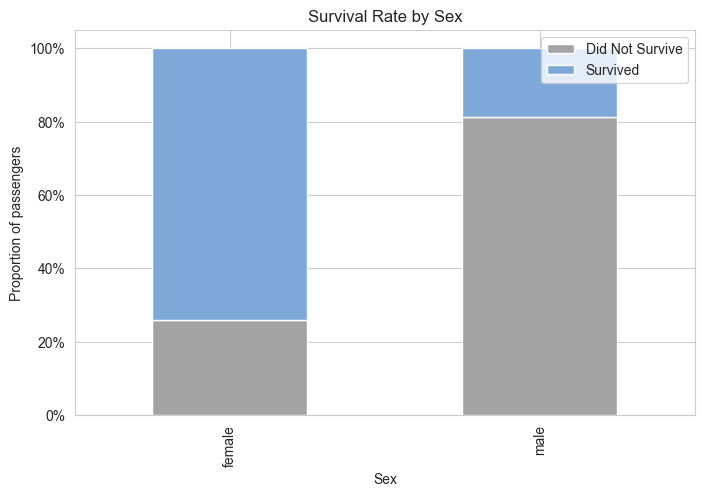

In [384]:

soft_colors = ['#a3a3a3', '#7da8d8'] 
gender_survival = train_df.groupby(['Sex','Survived']).size().unstack()
gender_survival_norm = gender_survival.div(gender_survival.sum(axis=1), axis=0)
gender_survival_norm.plot(kind='bar', stacked=True, color=soft_colors, figsize=(8,5))
plt.title('Survival Rate by Sex')
plt.ylabel('Proportion of passengers')
plt.legend(['Did Not Survive', 'Survived'], loc='upper right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()


## Survival rate by Pclass


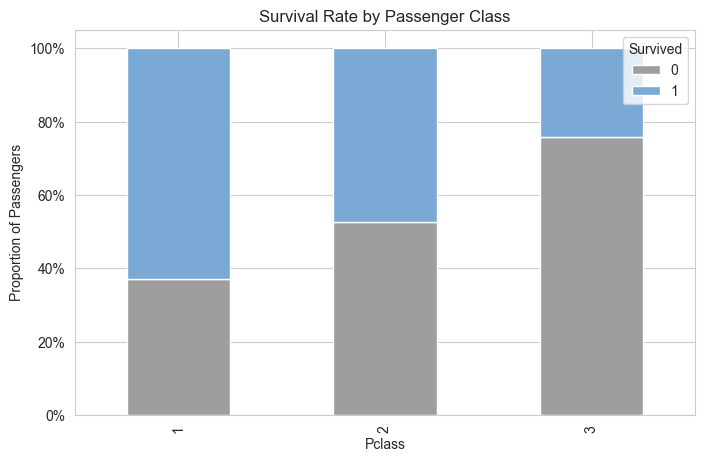

In [385]:
pclass_survival = train_df.groupby(['Pclass','Survived']).size().unstack()
pclass_survival_norm = pclass_survival.div(pclass_survival.sum(axis=1), axis=0)
pclass_survival_norm.plot(kind='bar', stacked=True, color=['#9e9e9e', '#7ba9d6'], figsize=(8,5))
plt.title('Survival Rate by Passenger Class') 
plt.ylabel('Proportion of Passengers')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Survival by Sex × Pclass (Heatmap)

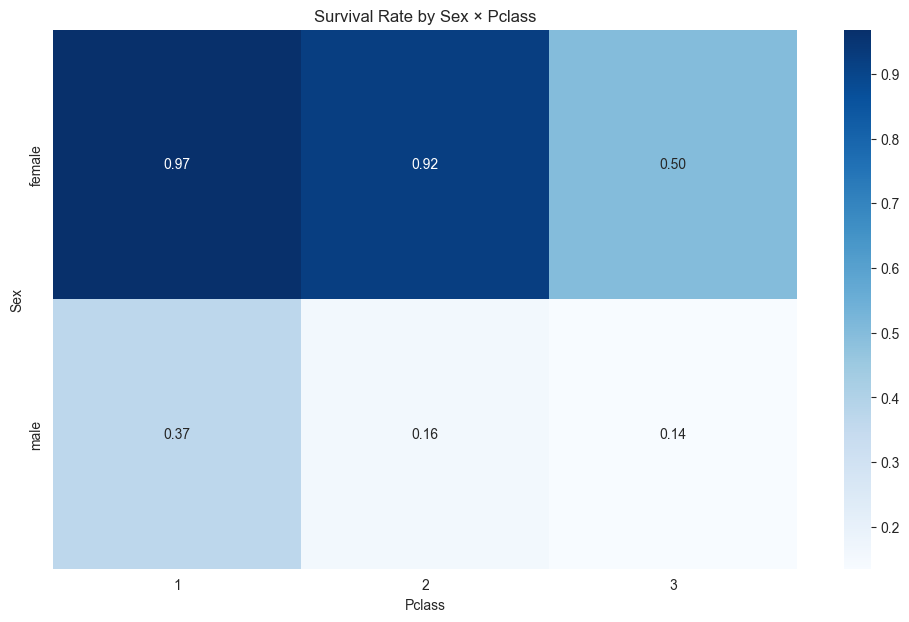

In [386]:
sex_pclass = pd.crosstab(train_df['Sex'], train_df['Pclass'], values=train_df['Survived'], aggfunc='mean')
sns.heatmap(sex_pclass, annot=True, cmap="Blues", fmt=".2f")
plt.title("Survival Rate by Sex × Pclass")
plt.show()


## Survival by Fare

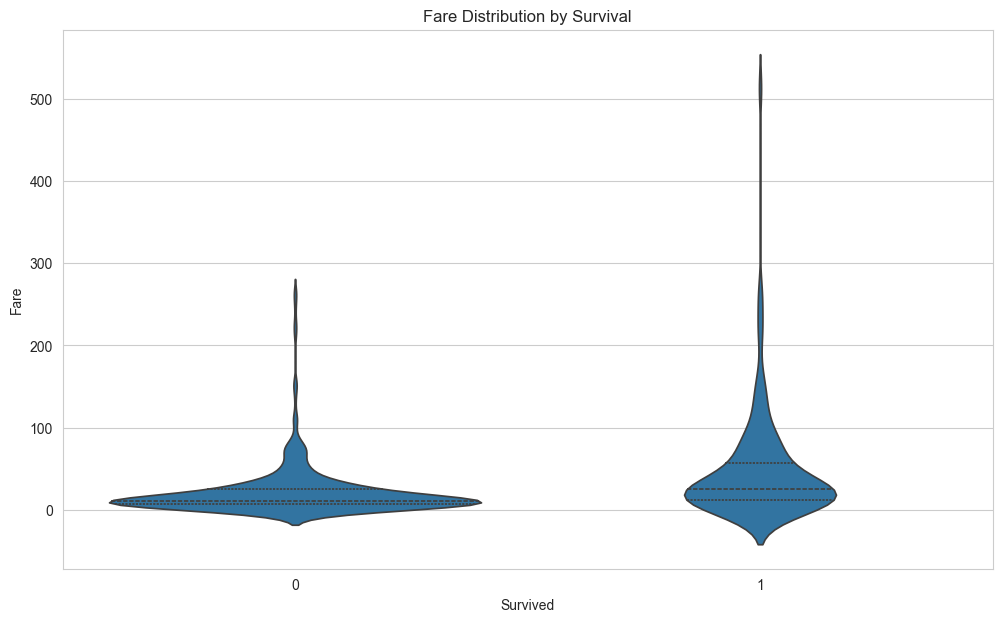

In [387]:
sns.violinplot(x="Survived", y="Fare", data=train_df, inner="quartile")
plt.title("Fare Distribution by Survival")
plt.show()


## Survival by Embarked

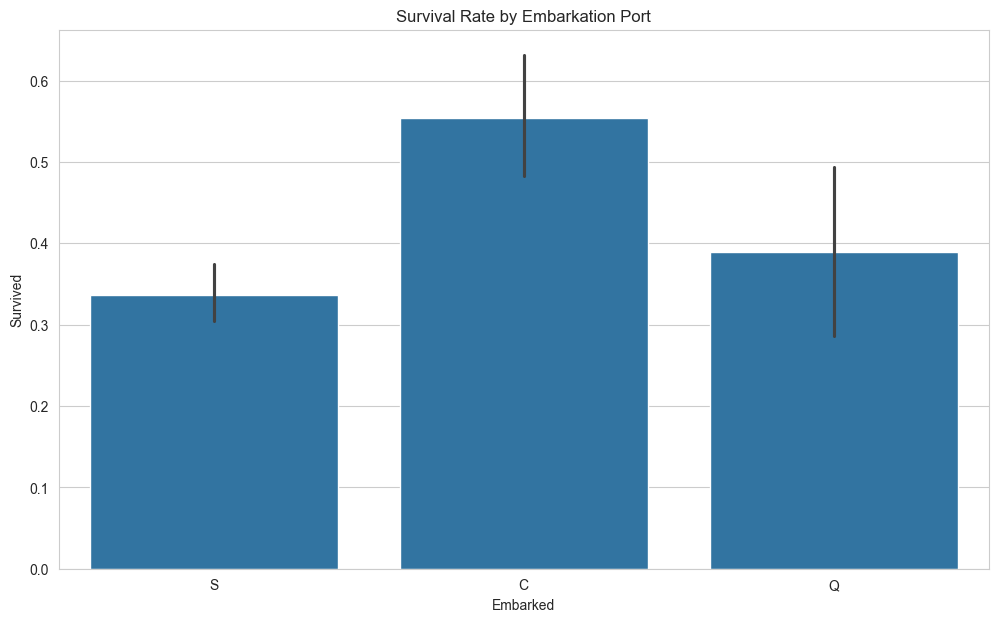

In [388]:
sns.barplot(x="Embarked", y="Survived", data=train_df)
plt.title("Survival Rate by Embarkation Port")
plt.show()


## Count of Survival

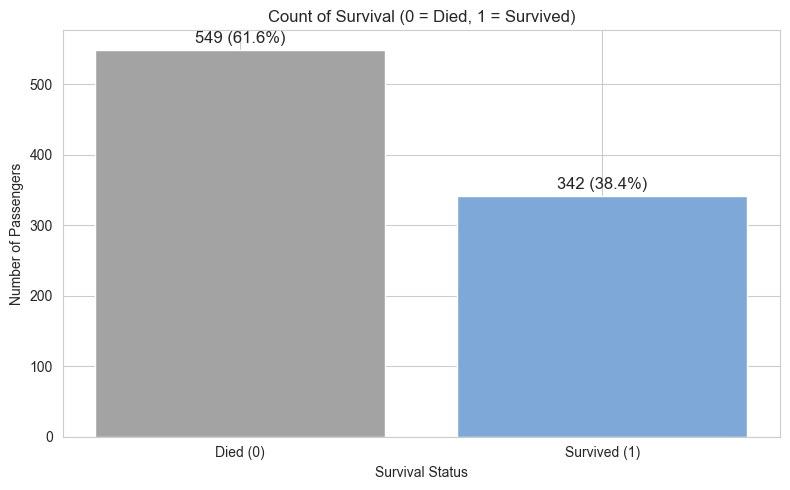

In [389]:
survived_counts = train_df['Survived'].value_counts().sort_index() 
colors = ['#a3a3a3', '#7da8d8']

plt.figure(figsize=(8,5))
plt.bar(x=[0,1], height=survived_counts.values, color=colors, tick_label=['Died (0)', 'Survived (1)'])
plt.title('Count of Survival (0 = Died, 1 = Survived)'); plt.xlabel('Survival Status'); plt.ylabel('Number of Passengers')

total = survived_counts.sum()
for i, count in enumerate(survived_counts.values):
    pct = count / total * 100
    plt.text(i, count + 10, f'{count} ({pct:.1f}%)', ha='center', fontsize=12)
plt.tight_layout()
plt.show()


## Age Distribution by Survival Status

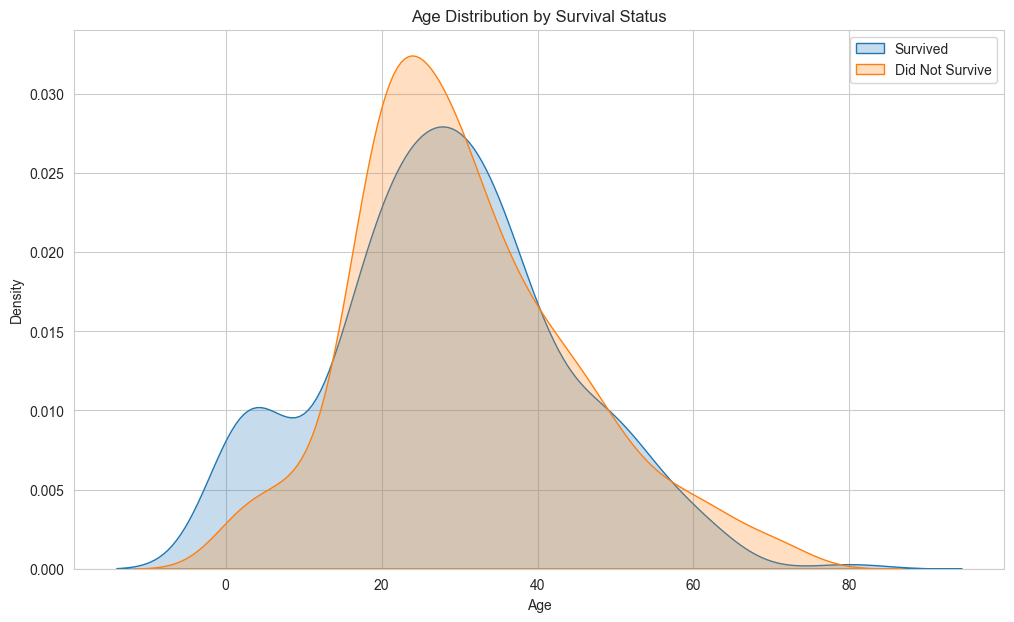

In [390]:
sns.kdeplot(data=train_df[train_df['Survived']==1], x='Age', fill=True, label='Survived')
sns.kdeplot(data=train_df[train_df['Survived']==0], x='Age', fill=True, label='Did Not Survive')
plt.title('Age Distribution by Survival Status')
plt.xlabel('Age')
plt.legend()
plt.show()


## FacetGrid: Age vs Survival

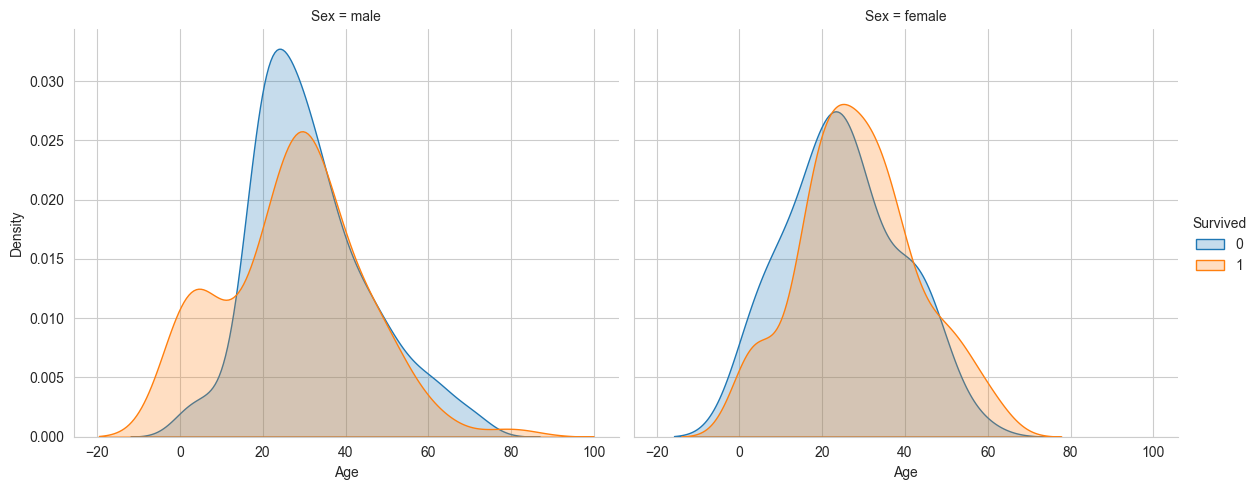

In [391]:
g = sns.FacetGrid(train_df, col="Sex", hue="Survived", height=5, aspect=1.2)
g.map(sns.kdeplot, "Age", fill=True)
g.add_legend()
plt.show()


## Feature Engineering

A passenger is more than a ticket:

- **`Title`** (from `Name`): social context and lifeboat priority proxies (`Mr`, `Miss`, `Mrs`, `Rare`).  
- **`FamilySize`** = `SibSp + Parch + 1`: group dynamics matter.  
- **`IsAlone`**: traveling solo vs with company.  
- **`CabinDeck`**: first letter of `Cabin` (unknown → `U`) as a **location proxy**.  
- **Age imputation** by `(Title, Sex, Pclass)` median, fallback to global median.  
- **Leak-safe encoding:** category maps learned on **train**, applied to **test**, unknowns → `-1`.

Each feature earns its seat by being intuitive, stable, and hard to leak.


In [392]:
def extract_title(name: str) -> str:
    m = re.search(r"([A-Za-z]+)\.", name)
    return m.group(1) if m else ""

## Titles

In [393]:
train_df["Title"] = train_df["Name"].map(extract_title)
test_df["Title"]  = test_df["Name"].map(extract_title)
rare_titles = ["Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"]
train_df["Title"] = train_df["Title"].replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"}).replace(rare_titles, "Rare")
test_df["Title"]  = test_df["Title"].replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"}).replace(rare_titles, "Rare")


## Family features

In [394]:
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"] + 1
test_df["FamilySize"]  = test_df["SibSp"] + test_df["Parch"] + 1
train_df["IsAlone"] = (train_df["FamilySize"] == 1).astype(int)
test_df["IsAlone"]  = (test_df["FamilySize"] == 1).astype(int)

## CabinDeck

In [395]:
train_df["CabinDeck"] = train_df["Cabin"].astype(str).str[0].replace({"n":"U"})
test_df["CabinDeck"]  = test_df["Cabin"].astype(str).str[0].replace({"n":"U"})

## Embarked

In [396]:
train_df["Embarked"].fillna(train_df["Embarked"].mode()[0], inplace=True)
test_df["Embarked"].fillna(train_df["Embarked"].mode()[0], inplace=True)

## Fare by Pclass

In [397]:
train_df["Fare"] = train_df["Fare"].fillna(train_df.groupby("Pclass")["Fare"].transform("median"))
test_df["Fare"]  = test_df["Fare"].fillna(test_df.groupby("Pclass")["Fare"].transform("median"))


## Age Median Train

In [398]:
age_group_median_train = train_df.groupby(["Title","Sex","Pclass"])["Age"].transform("median")
train_df["Age"] = train_df["Age"].fillna(age_group_median_train)
overall_age_median = train_df["Age"].median()
train_df["Age"] = train_df["Age"].fillna(overall_age_median)
age_keys = train_df.groupby(["Title","Sex","Pclass"])["Age"].median().to_dict()

test_df["Age"] = test_df.apply(
    lambda r: age_keys.get((r["Title"], r["Sex"], r["Pclass"]), overall_age_median)
              if pd.isna(r["Age"]) else r["Age"],
    axis=1
)

## Correlation Heatmap

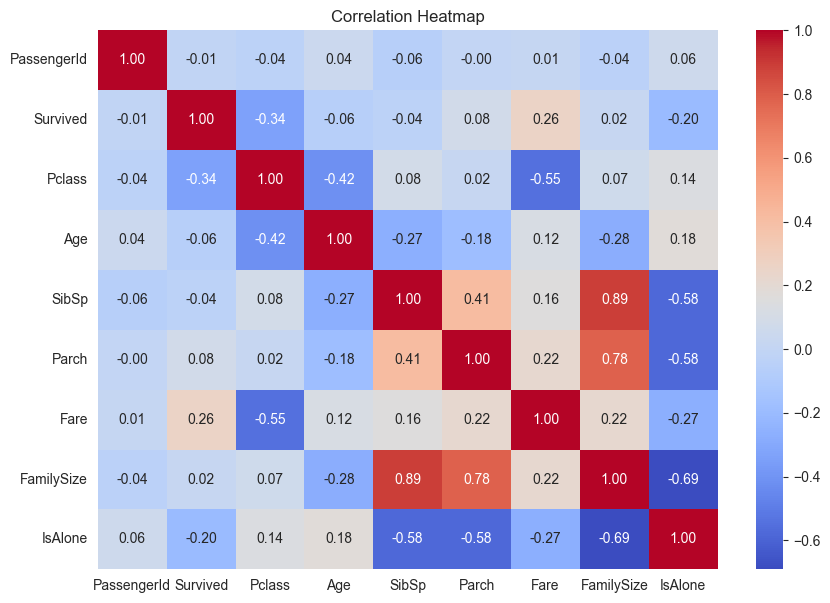

In [399]:
numeric_cols = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,7))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Family Size vs Survival

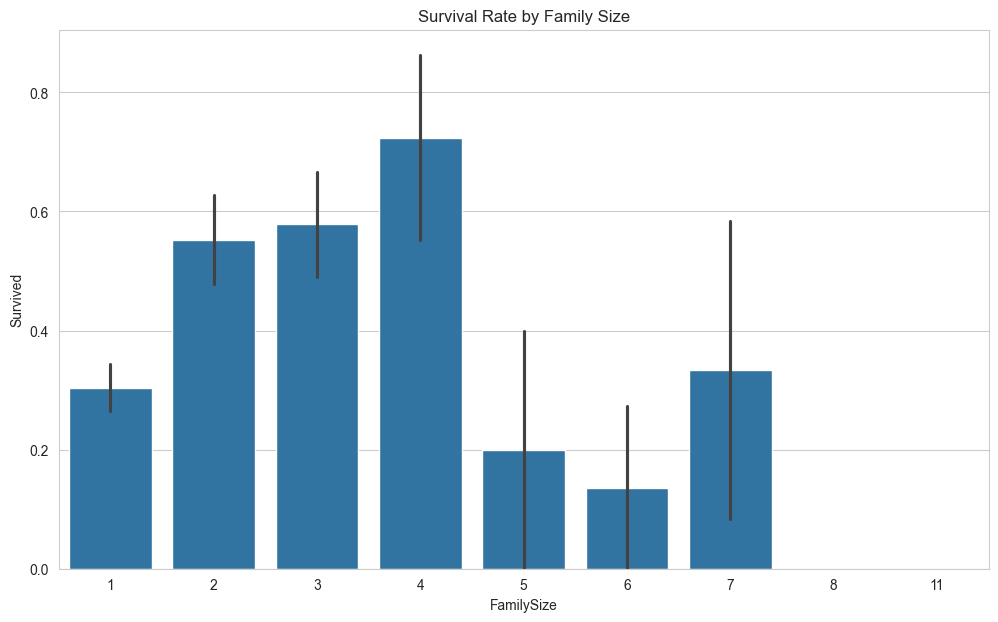

In [400]:
sns.barplot(x="FamilySize", y="Survived", data=train_df)
plt.title("Survival Rate by Family Size")
plt.show()


## Survival by Title 

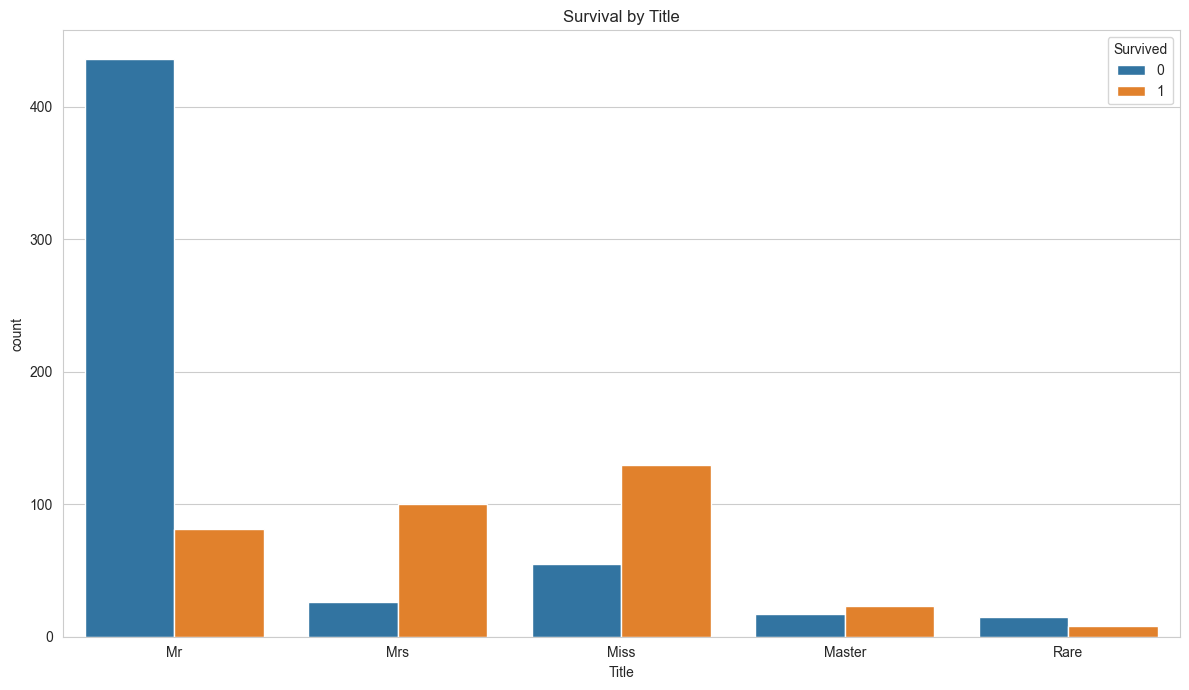

In [401]:
sns.countplot(x='Title', hue='Survived', data=train_df)
plt.title("Survival by Title")
plt.tight_layout()
plt.show()

# Leak-Safe Label Encoding

In [402]:
def fit_map(series: pd.Series):
    classes = pd.Index(series.astype(str).unique())
    return {cls: i for i, cls in enumerate(classes)}

def transform_with_map(series: pd.Series, mapping: dict, unk=-1):
    return series.astype(str).map(mapping).fillna(unk).astype(int)

sex_map      = fit_map(train_df["Sex"])
embarked_map = fit_map(train_df["Embarked"])
title_map    = fit_map(train_df["Title"])
deck_map     = fit_map(train_df["CabinDeck"])

for df in [train_df, test_df]:
    df["Sex"]       = transform_with_map(df["Sex"], sex_map)
    df["Embarked"]  = transform_with_map(df["Embarked"], embarked_map)
    df["Title"]     = transform_with_map(df["Title"], title_map)
    df["CabinDeck"] = transform_with_map(df["CabinDeck"], deck_map)


## Drop columns not used

In [403]:
drop_cols = ["Cabin","PassengerId","Name","Ticket"]
train_df = train_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

## Modeling Arena — Which Model Tells the Better Story?

Four checkpoints:

1) **Baseline:** Logistic Regression (simple, interpretable).  
2) **Main model:** RandomForest with `class_weight="balanced"` to soften imbalance.  
3) **Validation metrics @0.5:** Accuracy, F1, ROC-AUC, plus confusion matrices.  
4) **Threshold tuning:** choose the RF probability cutoff that **maximizes F1** on the validation split, then **reuse** it for test.

> **Why F1?** It balances precision and recall—useful when both false negatives and false positives matter.



# Split & Model

In [404]:
X = train_df.drop("Survived", axis=1)
y = train_df["Survived"].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=RNG, stratify=y
)

## Baselines 

In [405]:
logit = LogisticRegression(max_iter=1000, n_jobs=None)  
rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=RNG,
    n_jobs=-1,
    class_weight="balanced"
)

## Train

In [406]:
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=300, n_jobs=-1,
                       random_state=42)

## Validation


=== LogisticRegression @0.5 ===
Accuracy   : 0.8156
F1         : 0.7481
ROC-AUC    : 0.8561
              precision    recall  f1-score   support

           0     0.8291    0.8818    0.8546       110
           1     0.7903    0.7101    0.7481        69

    accuracy                         0.8156       179
   macro avg     0.8097    0.7960    0.8014       179
weighted avg     0.8141    0.8156    0.8136       179



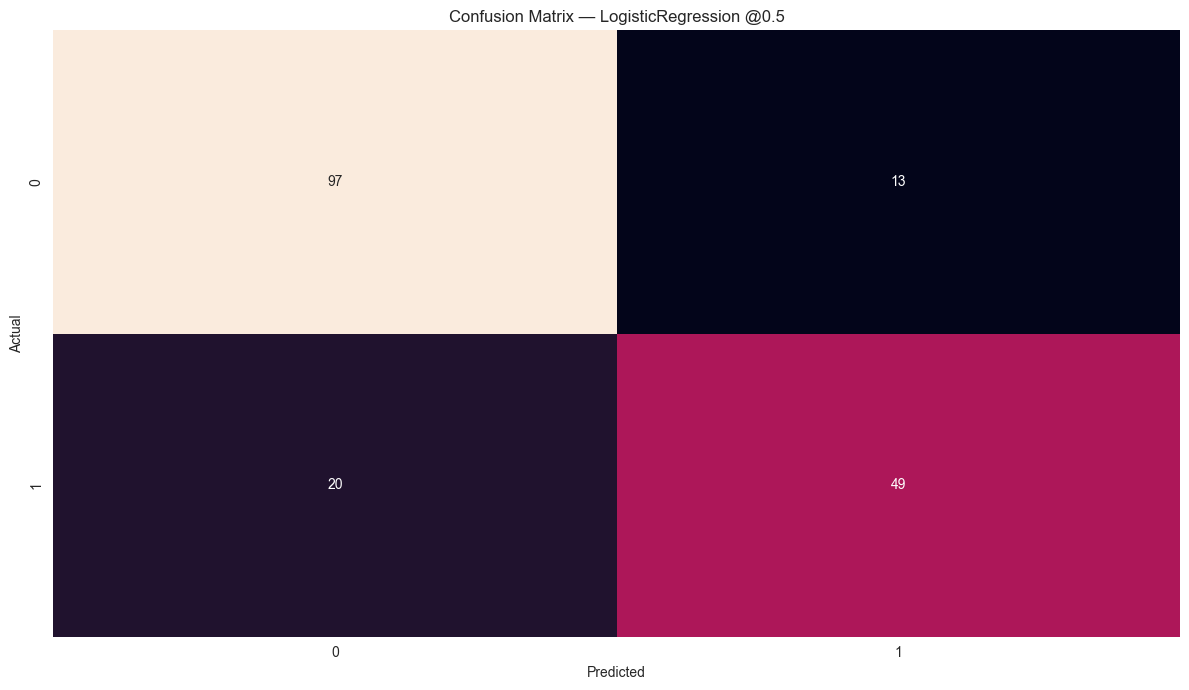


=== RandomForest @0.5 ===
Accuracy   : 0.8212
F1         : 0.7647
ROC-AUC    : 0.8626
              precision    recall  f1-score   support

           0     0.8482    0.8636    0.8559       110
           1     0.7761    0.7536    0.7647        69

    accuracy                         0.8212       179
   macro avg     0.8122    0.8086    0.8103       179
weighted avg     0.8204    0.8212    0.8207       179



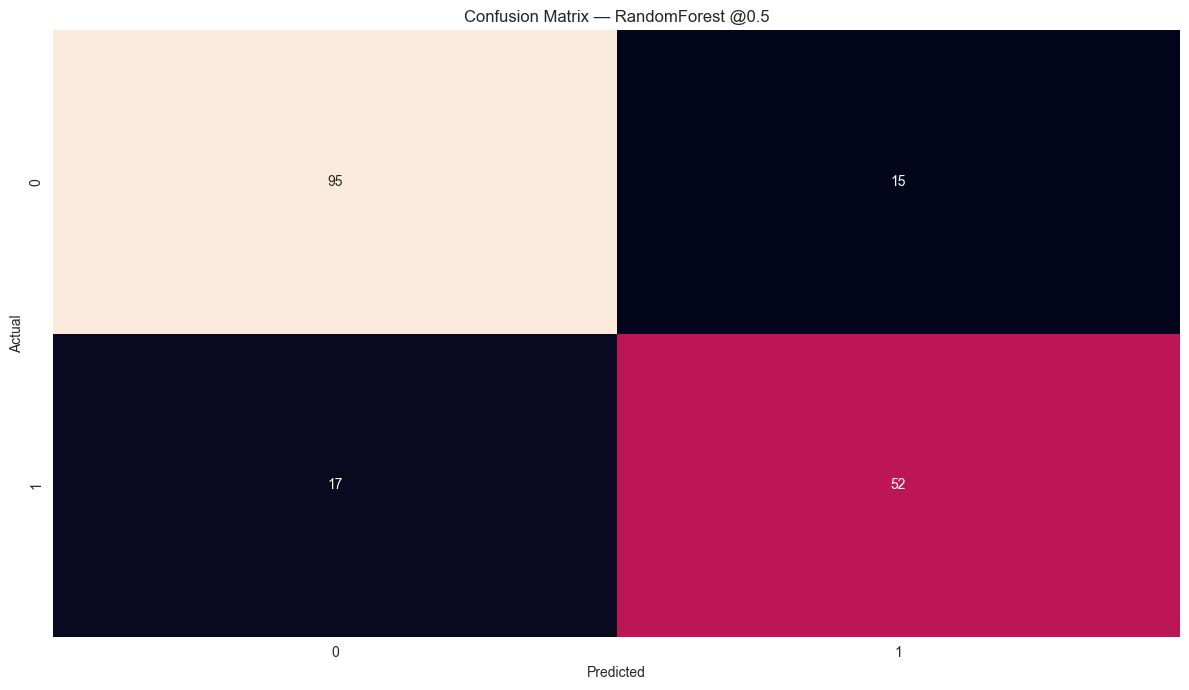

In [407]:
def evaluate(model, name):
    proba = model.predict_proba(X_valid)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_valid)
    y_pred = (proba >= 0.5).astype(int)
    print(f"\n=== {name} @0.5 ===")
    print(f"Accuracy   : {accuracy_score(y_valid, y_pred):.4f}")
    print(f"F1         : {f1_score(y_valid, y_pred):.4f}")
    try:
        print(f"ROC-AUC    : {roc_auc_score(y_valid, proba):.4f}")
    except Exception:
        pass
    print(classification_report(y_valid, y_pred, digits=4))
    cm = confusion_matrix(y_valid, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix — {name} @0.5")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()
    return proba

proba_logit = evaluate(logit, "LogisticRegression")
proba_rf    = evaluate(rf, "RandomForest")


## [Exploration only] Blending on validation for curiosity — not used for final predictions


# Best blended threshold by ACC

In [408]:
proba_blend_valid = 0.6*proba_rf + 0.4*proba_logit  
ths = np.linspace(0.3, 0.7, 81)
accs = [accuracy_score(y_valid, (proba_blend_valid >= t).astype(int)) for t in ths]
best_th_blend = ths[int(np.argmax(accs))]
print(f"Best blended threshold by ACC: {best_th_blend:.3f} | ACC={max(accs):.4f}")


Best blended threshold by ACC: 0.465 | ACC=0.8324


# Cross-Validation (RF vs LogisticRegression)

In [409]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
def quick_cv(est, X, y, name):
    scores = cross_validate(est, X, y, cv=cv, scoring=["accuracy","f1","roc_auc"], n_jobs=-1)
    print(f"{name:>18} | ACC {scores['test_accuracy'].mean():.3f}±{scores['test_accuracy'].std():.3f} | "
          f"F1 {scores['test_f1'].mean():.3f}±{scores['test_f1'].std():.3f} | "
          f"AUC {scores['test_roc_auc'].mean():.3f}±{scores['test_roc_auc'].std():.3f}")

quick_cv(LogisticRegression(max_iter=1000), X, y, "Logistic CV")
quick_cv(RandomForestClassifier(
    n_estimators=300, min_samples_split=4, min_samples_leaf=2, max_features="sqrt",
    random_state=RNG, n_jobs=-1, class_weight="balanced"
), X, y, "RF CV")


       Logistic CV | ACC 0.811±0.021 | F1 0.746±0.039 | AUC 0.860±0.019
             RF CV | ACC 0.831±0.009 | F1 0.777±0.014 | AUC 0.883±0.017



## Importance (Permutation + RF importances)

Two complementary lenses:

- **RandomForest importances:** quick signal ranking.  
- **Permutation importance:** model-agnostic test of each feature’s *true* contribution by shuffling it.

Together, they explain **what** the model uses and **how much** it helps.

---


In [410]:
perm = permutation_importance(
    rf, X_valid, y_valid,
    n_repeats=20 if not FAST_MODE else 5,
    random_state=RNG, n_jobs=-1
)

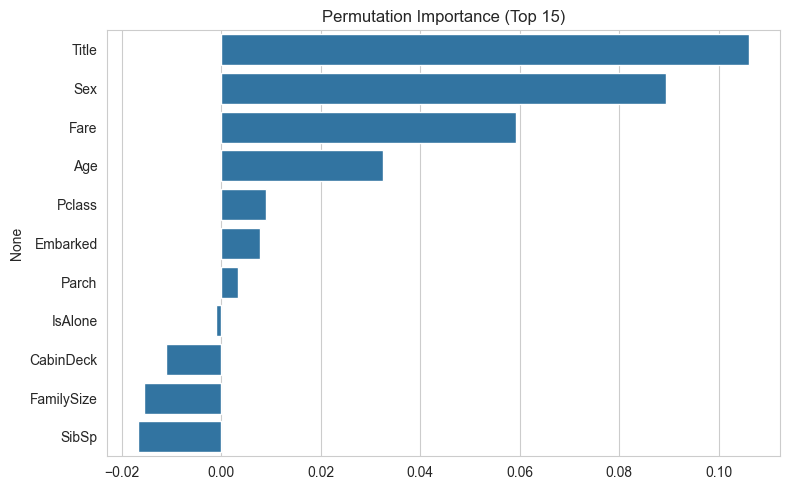

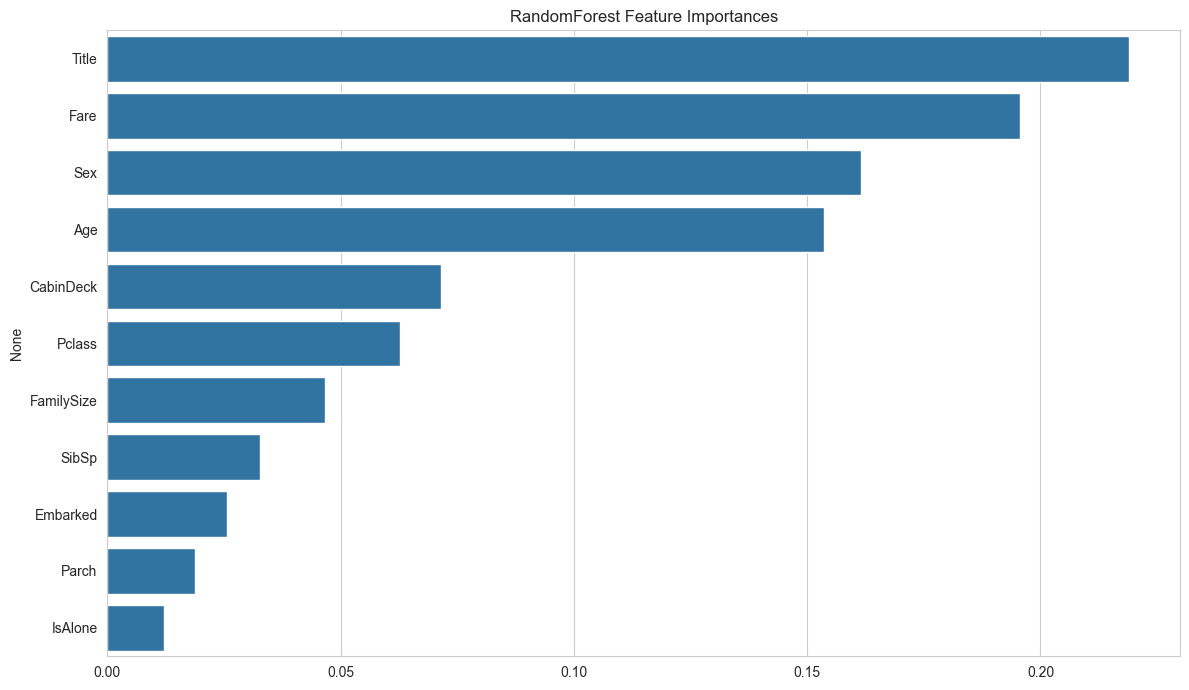

In [411]:
pi = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,5))
sns.barplot(x=pi.values, y=pi.index)
plt.title("Permutation Importance (Top 15)")
plt.tight_layout(); plt.show()

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
sns.barplot(x=importances.values, y=importances.index)
plt.title("RandomForest Feature Importances")
plt.tight_layout(); plt.show()

## Learning & Validation Curves

- **Learning Curve:** how performance scales with more training data; reveals under/overfitting regimes.  
- **Validation Curve (`n_estimators`)**: sensitivity to tree count while holding other RF settings fixed; shows diminishing returns.

These plots keep us honest about data quantity and capacity.

In [ ]:
lc_cv = 3 if FAST_MODE else 5
lc_sizes = np.linspace(0.2, 1.0, 5)

lc_sizes, lc_train_scores, lc_valid_scores = learning_curve(
    rf, X, y,
    cv=lc_cv,
    train_sizes=lc_sizes,
    n_jobs=-1,
    shuffle=True,
    random_state=RNG
)

plt.figure()
plt.plot(lc_sizes, lc_train_scores.mean(axis=1), marker="o", label="Train")
plt.plot(lc_sizes, lc_valid_scores.mean(axis=1), marker="o", label="CV")
plt.title("Learning Curve — RandomForest")
plt.xlabel("Train size"); plt.ylabel("Accuracy")
plt.legend(); plt.tight_layout(); plt.show()

param_range = [50, 100, 200, 300, 500]

rf_for_val = RandomForestClassifier(
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=RNG,
    n_jobs=-1,
    class_weight="balanced",
)

vc_train_scores, vc_valid_scores = validation_curve(
    rf_for_val,
    X, y,
    param_name="n_estimators",
    param_range=param_range,
    cv=3 if FAST_MODE else 5,
    scoring="accuracy",
    n_jobs=-1
)

plt.figure()
plt.plot(param_range, vc_train_scores.mean(axis=1), marker="o", label="Train")
plt.plot(param_range, vc_valid_scores.mean(axis=1), marker="o", label="CV")
plt.title("Validation Curve — RandomForest (n_estimators)")
plt.xlabel("n_estimators"); plt.ylabel("Accuracy")
plt.legend(); plt.tight_layout(); plt.show()


# Final Training + Threshold (F1 on RF)

In [ ]:
prec_rf, rec_rf, th_rf = precision_recall_curve(y_valid, proba_rf)
f1_rf = 2*prec_rf*rec_rf/(prec_rf+rec_rf+1e-9)
best_idx_rf = np.argmax(f1_rf)
best_th = th_rf[best_idx_rf] if best_idx_rf < len(th_rf) else 0.5
print(f"\nBest RF threshold (F1): {best_th:.3f} | F1={f1_rf[best_idx_rf]:.4f}")

rf.fit(X, y)
test_proba = rf.predict_proba(test_df[X.columns])[:,1]
test_pred  = (test_proba >= best_th).astype(int)




Best RF threshold (F1): 0.529 | F1=0.7820


In [ ]:
def line(name, proba, th):
    yhat = (proba >= th).astype(int)
    print(f"{name:22s} | TH={th:0.3f} | ACC={accuracy_score(y_valid,yhat):.3f} | F1={f1_score(y_valid,yhat):.3f} | AUC={roc_auc_score(y_valid,proba):.3f}")

print("\n=== Validation Scoreboard ===")
line("Logistic (0.5)", proba_logit, 0.5)
line("RandomForest (0.5)", proba_rf, 0.5)
line("RandomForest (best)", proba_rf, best_th)




=== Validation Scoreboard ===
Logistic (0.5)         | TH=0.500 | ACC=0.816 | F1=0.748 | AUC=0.856
RandomForest (0.5)     | TH=0.500 | ACC=0.821 | F1=0.765 | AUC=0.863
RandomForest (best)    | TH=0.529 | ACC=0.838 | F1=0.782 | AUC=0.863


# Sanity

In [ ]:
assert set(np.unique(test_pred)).issubset({0,1})
assert not np.isnan(test_pred).any()
print("Test positive rate:", float(test_pred.mean()))


Test positive rate: 0.3660287081339713


In [ ]:
print("Any NaN in X?", X.isna().any().any())
print("Any NaN in test?", test_df[X.columns].isna().any().any())

Any NaN in X? False
Any NaN in test? False


# Submission 

In [ ]:
submission = pd.DataFrame({"PassengerId": passenger_ids, "Survived": test_pred.astype(int)})
submission.to_csv("submission.csv", index=False)
print("Saved: submission.csv")

Saved: submission.csv
